In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
import json
import gc

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 45.1 MB/s eta 0:00:0000:0100:01


In [4]:
# ===============================
# 1. DATASET CLASS
# ===============================

class BinaryCloudDataset(Dataset):
    def __init__(self, images_dir, masks_dir, channel_means, channel_stds, target_class):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.channel_means = np.array(channel_means)
        self.channel_stds = np.array(channel_stds)
        self.target_class = target_class
        
        # Get all image files
        image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.tif')])
        self.pairs = []
        
        for img_file in image_files:
            # Handle both original and augmented files
            if '_shadowaug_' in img_file:
                # Augmented file: "name_shadowaug_001.tif" -> "name_shadowaug_001_mask.tif"
                mask_file = img_file.replace('.tif', '_mask.tif')
            else:
                # Original file: "name_123.tif" -> "name_mask_123.tif"
                base, idx = img_file.rsplit('_', 1)
                mask_file = base + '_mask_' + idx
            
            mask_path = os.path.join(masks_dir, mask_file)
            img_path = os.path.join(images_dir, img_file)
            
            if os.path.exists(mask_path):
                self.pairs.append((img_path, mask_path))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        
        # Load image (RGB)
        with rasterio.open(img_path) as src:
            image = np.stack([src.read(1), src.read(2), src.read(3)], axis=0)
            image = np.nan_to_num(image, nan=0.0).astype(np.float32)
            
            # Normalize
            for i in range(3):
                image[i] = (image[i] - self.channel_means[i]) / self.channel_stds[i]
        
        # Load mask
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)
        
        # Create binary mask for target class
        binary_mask = (mask == self.target_class).astype(np.float32)
        
        return torch.tensor(image, dtype=torch.float32), torch.tensor(binary_mask, dtype=torch.float32)


In [5]:
# ===============================
# 2. UNET MODEL ARCHITECTURE
# ===============================

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        # Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)
        
        # Output
        self.outc = nn.Conv2d(64, n_classes, 1)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder with skip connections
        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv3(x)
        
        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv4(x)
        
        logits = self.outc(x)
        return logits


In [6]:
# ===============================
# 3. LOSS FUNCTIONS
# ===============================

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(inputs)
        
        # Calculate focal loss
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = alpha_t * (1 - p_t) ** self.gamma
        
        # Binary cross entropy loss
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            inputs, targets, reduction='none'
        )
        
        focal_loss = focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities
        inputs_sigmoid = torch.sigmoid(inputs)
        
        # Flatten tensors
        inputs_flat = inputs_sigmoid.view(-1)
        targets_flat = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (inputs_flat * targets_flat).sum()
        union = inputs_flat.sum() + targets_flat.sum() - intersection
        
        # IoU calculation
        iou = (intersection + self.smooth) / (union + self.smooth)
        
        # Return 1 - IoU as loss
        return 1 - iou

In [7]:
# ===============================
# 4. METRICS CALCULATION
# ===============================

def compute_metrics(y_true, y_pred, threshold=0.5):
    """Compute comprehensive metrics for binary segmentation"""
    
    # Convert to binary predictions
    y_pred_binary = (y_pred > threshold).astype(np.uint8)
    y_true_binary = y_true.astype(np.uint8)
    
    # Flatten arrays
    y_true_flat = y_true_binary.flatten()
    y_pred_flat = y_pred_binary.flatten()
    
    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1]).ravel()
    
    # Calculate metrics
    metrics = {}
    
    # Target class metrics (class 1)
    target_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    target_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    target_f1 = 2 * target_precision * target_recall / (target_precision + target_recall) if (target_precision + target_recall) > 0 else 0
    target_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0
    
    # Background class metrics (class 0)
    bg_precision = tn / (tn + fn) if (tn + fn) > 0 else 0
    bg_recall = tn / (tn + fp) if (tn + fp) > 0 else 0
    bg_f1 = 2 * bg_precision * bg_recall / (bg_precision + bg_recall) if (bg_precision + bg_recall) > 0 else 0
    bg_iou = tn / (tn + fp + fn) if (tn + fp + fn) > 0 else 0
    
    # Overall accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Combined IoU
    combined_iou = (target_iou + bg_iou) / 2
    
    metrics = {
        'target_precision': target_precision,
        'target_recall': target_recall,
        'target_f1': target_f1,
        'target_iou': target_iou,
        'bg_precision': bg_precision,
        'bg_recall': bg_recall,
        'bg_f1': bg_f1,
        'bg_iou': bg_iou,
        'accuracy': accuracy,
        'combined_iou': combined_iou
    }
    
    return metrics

In [8]:
# ===============================
# 5. TRAINING FUNCTION
# ===============================

def train_binary_unet(model, train_loader, val_loader, class_name, device, 
                     num_epochs=50, learning_rate=1e-4, focal_alpha=0.9, focal_gamma=2.0):
    """Train a binary UNet model with comprehensive logging"""
    
    print(f"\n🚀 TRAINING {class_name} BINARY UNET")
    print("="*60)
    
    # Loss functions
    focal_criterion = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
    iou_criterion = IoULoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )
    
    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_combined_iou': [], 'val_combined_iou': [],
        'val_target_iou': [], 'val_bg_iou': [],
        'val_target_f1': [], 'val_bg_f1': [],
        'val_accuracy': []
    }
    
    best_combined_iou = 0.0
    best_epoch = 0
    patience_counter = 0
    patience_limit = 10
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # ==================
        # TRAINING PHASE
        # ==================
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        
        for batch_idx, (images, targets) in enumerate(train_pbar):
            images, targets = images.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images).squeeze(1)
            
            # Calculate losses
            focal_loss = focal_criterion(outputs, targets)
            iou_loss = iou_criterion(outputs, targets)
            total_loss = focal_loss + iou_loss
            
            # Backward pass
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
            
            # Store predictions for metrics
            with torch.no_grad():
                probs = torch.sigmoid(outputs)
                train_preds.append(probs.cpu().numpy())
                train_targets.append(targets.cpu().numpy())
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{total_loss.item():.4f}',
                'Focal': f'{focal_loss.item():.4f}',
                'IoU': f'{iou_loss.item():.4f}'
            })
        
        # Calculate training metrics
        train_preds = np.concatenate(train_preds)
        train_targets = np.concatenate(train_targets)
        train_metrics = compute_metrics(train_targets, train_preds)
        
        # ==================
        # VALIDATION PHASE
        # ==================
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            
            for images, targets in val_pbar:
                images, targets = images.to(device), targets.to(device)
                
                # Forward pass
                outputs = model(images).squeeze(1)
                
                # Calculate losses
                focal_loss = focal_criterion(outputs, targets)
                iou_loss = iou_criterion(outputs, targets)
                total_loss = focal_loss + iou_loss
                
                val_loss += total_loss.item()
                
                # Store predictions
                probs = torch.sigmoid(outputs)
                val_preds.append(probs.cpu().numpy())
                val_targets.append(targets.cpu().numpy())
                
                val_pbar.set_postfix({'Loss': f'{total_loss.item():.4f}'})
        
        # Calculate validation metrics
        val_preds = np.concatenate(val_preds)
        val_targets = np.concatenate(val_targets)
        val_metrics = compute_metrics(val_targets, val_preds)
        
        # Average losses
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_combined_iou'].append(train_metrics['combined_iou'])
        history['val_combined_iou'].append(val_metrics['combined_iou'])
        history['val_target_iou'].append(val_metrics['target_iou'])
        history['val_bg_iou'].append(val_metrics['bg_iou'])
        history['val_target_f1'].append(val_metrics['target_f1'])
        history['val_bg_f1'].append(val_metrics['bg_f1'])
        history['val_accuracy'].append(val_metrics['accuracy'])
        
        # Learning rate scheduling
        scheduler.step(val_metrics['combined_iou'])
        
        # Print epoch results
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} - {epoch_time:.1f}s")
        print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"Train Combined IoU: {train_metrics['combined_iou']:.4f} | Val Combined IoU: {val_metrics['combined_iou']:.4f}")
        
        print(f"\n🎯 {class_name.upper()} CLASS METRICS:")
        print(f" IoU: {val_metrics['target_iou']:.4f}")
        print(f" Accuracy: {val_metrics['accuracy']:.4f}")
        print(f" Precision: {val_metrics['target_precision']:.4f}")
        print(f" Recall: {val_metrics['target_recall']:.4f}")
        print(f" F1 Score: {val_metrics['target_f1']:.4f}")
        
        print(f"\n🌫️ BACKGROUND CLASS METRICS:")
        print(f" IoU: {val_metrics['bg_iou']:.4f}")
        print(f" Precision: {val_metrics['bg_precision']:.4f}")
        print(f" Recall: {val_metrics['bg_recall']:.4f}")
        print(f" F1 Score: {val_metrics['bg_f1']:.4f}")
        
        # Save best model
        if val_metrics['combined_iou'] > best_combined_iou:
            best_combined_iou = val_metrics['combined_iou']
            best_epoch = epoch
            patience_counter = 0
            
            # Save model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_combined_iou': best_combined_iou,
                'class_name': class_name,
                'history': history
            }, f'best_unet_{class_name.lower()}.pth')
            
            print(f"✅ New best model saved! Combined IoU: {best_combined_iou:.4f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience_limit:
            print(f"\n⏹️ Early stopping at epoch {epoch+1}")
            print(f"Best Combined IoU: {best_combined_iou:.4f} at epoch {best_epoch+1}")
            break
        
        print("-" * 80)
        
        # Memory cleanup
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    print(f"\n🏆 TRAINING COMPLETE FOR {class_name}")
    print(f"Best Combined IoU: {best_combined_iou:.4f} at epoch {best_epoch+1}")
    
    return history, best_combined_iou

In [9]:
# ===============================
# 6. MAIN TRAINING PIPELINE
# ===============================

def main_training_pipeline():
    """Main training pipeline for all 3 binary models"""
    
    print("🚀 STARTING BINARY CLOUD SEGMENTATION TRAINING")
    print("="*70)
    
    # Configuration
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Dataset paths - UPDATE THESE TO YOUR AUGMENTED DATASET
    root_data_dir = '/kaggle/input/new-nrsc-no-corrupte-limited/Final_Dataset_Limited'  # Your augmented dataset folder
    means = [0.3813302780979631, 0.4006466170724529, 0.4106628602303568]
    stds  = [0.2407521328203374, 0.2612074618803232, 0.20322935788977547]
    
    # Normalization parameters - UPDATE THESE WITH YOUR NEW VALUES
    #means = [0.32006399, 0.33146843, 0.37131852]  # Update with your new means
    #stds = [0.22127256, 0.24326983, 0.17580849]   # Update with your new stds
    
    print(f"Dataset: {root_data_dir}")
    print(f"Means: {means}")
    print(f"Stds: {stds}")
    
    # Class information
    class_names = ['NOCLOUD', 'CLOUD', 'SHADOW']
    class_configs = {
        0: {'name': 'NOCLOUD', 'focal_alpha': 0.8, 'focal_gamma': 2.0},
        1: {'name': 'CLOUD', 'focal_alpha': 0.9, 'focal_gamma': 2.0},
        2: {'name': 'SHADOW', 'focal_alpha': 0.9, 'focal_gamma': 3.0}  # Higher gamma for shadow
    }
    
    # Training results storage
    all_results = {}
    
    # Train each binary model
    for target_class in [0, 1, 2]:
        config = class_configs[target_class]
        class_name = config['name']
        
        print(f"\n{'='*20} TRAINING {class_name} MODEL {'='*20}")
        
        # Create datasets
        train_dataset = BinaryCloudDataset(
            os.path.join(root_data_dir, 'train', 'images'),
            os.path.join(root_data_dir, 'train', 'masks'),
            means, stds, target_class
        )
        
        val_dataset = BinaryCloudDataset(
            os.path.join(root_data_dir, 'val', 'images'),
            os.path.join(root_data_dir, 'val', 'masks'),
            means, stds, target_class
        )
        
        print(f"Train samples: {len(train_dataset)}")
        print(f"Val samples: {len(val_dataset)}")
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset, batch_size=BATCH_SIZE, shuffle=True,
            num_workers=4, pin_memory=True
        )
        
        val_loader = DataLoader(
            val_dataset, batch_size=BATCH_SIZE, shuffle=False,
            num_workers=4, pin_memory=True
        )
        
        # Create model
        model = UNet(n_channels=3, n_classes=1).to(device)
        
        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
        # Train model
        history, best_iou = train_binary_unet(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            class_name=class_name,
            device=device,
            num_epochs=NUM_EPOCHS,
            learning_rate=LEARNING_RATE,
            focal_alpha=config['focal_alpha'],
            focal_gamma=config['focal_gamma']
        )
        
        # Store results
        all_results[class_name] = {
            'best_combined_iou': best_iou,
            'history': history
        }
        
        # Save training history
        with open(f'training_history_{class_name.lower()}.json', 'w') as f:
            # Convert numpy arrays to lists for JSON serialization
            json_history = {}
            for key, value in history.items():
                if isinstance(value, list):
                    json_history[key] = [float(v) if not np.isnan(v) else 0.0 for v in value]
                else:
                    json_history[key] = float(value) if not np.isnan(value) else 0.0
            json.dump(json_history, f, indent=2)
        
        print(f"\n✅ {class_name} training complete!")
        print(f"Best Combined IoU: {best_iou:.4f}")
        
        # Memory cleanup
        del model, train_loader, val_loader, train_dataset, val_dataset
        gc.collect()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Final summary
    print(f"\n🎉 ALL MODELS TRAINING COMPLETE!")
    print("="*70)
    print("FINAL RESULTS SUMMARY:")
    for class_name, results in all_results.items():
        print(f"{class_name:8}: {results['best_combined_iou']:.4f} Combined IoU")
    
    return all_results

In [10]:
# ===============================
# 7. RUN TRAINING
# ===============================

if __name__ == "__main__":
    # Run the complete training pipeline
    results = main_training_pipeline()
    
    print("\n🏆 Training pipeline completed successfully!")
    print("Check saved model files: best_unet_nocloud.pth, best_unet_cloud.pth, best_unet_shadow.pth")
    print("Check training histories: training_history_*.json")

🚀 STARTING BINARY CLOUD SEGMENTATION TRAINING
Using device: cuda
Dataset: /kaggle/input/new-nrsc-no-corrupte-limited/Final_Dataset_Limited
Means: [0.3813302780979631, 0.4006466170724529, 0.4106628602303568]
Stds: [0.2407521328203374, 0.2612074618803232, 0.20322935788977547]

==================== TRAINING NOCLOUD MODEL ====================
Train samples: 2300
Val samples: 412
Total parameters: 31,043,521
Trainable parameters: 31,043,521

🚀 TRAINING NOCLOUD BINARY UNET


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  5.60it/s, Loss=0.2106]



Epoch 1/50 - 67.2s
Train Loss: 0.3884 | Val Loss: 0.4428
Train Combined IoU: 0.7699 | Val Combined IoU: 0.8603

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8568
 Accuracy: 0.9250
 Precision: 0.8787
 Recall: 0.9718
 F1 Score: 0.9229

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8638
 Precision: 0.9733
 Recall: 0.8848
 F1 Score: 0.9269
✅ New best model saved! Combined IoU: 0.8603
--------------------------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.1885]



Epoch 2/50 - 65.0s
Train Loss: 0.3324 | Val Loss: 0.4789
Train Combined IoU: 0.7937 | Val Combined IoU: 0.8448

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8366
 Accuracy: 0.9161
 Precision: 0.8932
 Recall: 0.9296
 F1 Score: 0.9110

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8529
 Precision: 0.9373
 Recall: 0.9045
 F1 Score: 0.9206
--------------------------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.07it/s, Loss=0.1680]



Epoch 3/50 - 65.1s
Train Loss: 0.3191 | Val Loss: 0.4098
Train Combined IoU: 0.7903 | Val Combined IoU: 0.8683

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8662
 Accuracy: 0.9295
 Precision: 0.8754
 Recall: 0.9881
 F1 Score: 0.9283

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8703
 Precision: 0.9885
 Recall: 0.8792
 F1 Score: 0.9306
✅ New best model saved! Combined IoU: 0.8683
--------------------------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.1852]



Epoch 4/50 - 65.0s
Train Loss: 0.2862 | Val Loss: 0.3792
Train Combined IoU: 0.8089 | Val Combined IoU: 0.8750

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8723
 Accuracy: 0.9334
 Precision: 0.8843
 Recall: 0.9846
 F1 Score: 0.9318

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8778
 Precision: 0.9854
 Recall: 0.8894
 F1 Score: 0.9349
✅ New best model saved! Combined IoU: 0.8750
--------------------------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s, Loss=0.1209]



Epoch 5/50 - 65.0s
Train Loss: 0.2757 | Val Loss: 0.3417
Train Combined IoU: 0.8151 | Val Combined IoU: 0.8830

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8803
 Accuracy: 0.9379
 Precision: 0.8896
 Recall: 0.9882
 F1 Score: 0.9363

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8857
 Precision: 0.9888
 Recall: 0.8947
 F1 Score: 0.9394
✅ New best model saved! Combined IoU: 0.8830
--------------------------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.1425]



Epoch 6/50 - 65.0s
Train Loss: 0.2646 | Val Loss: 0.3453
Train Combined IoU: 0.8200 | Val Combined IoU: 0.8818

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8797
 Accuracy: 0.9372
 Precision: 0.8849
 Recall: 0.9934
 F1 Score: 0.9360

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8840
 Precision: 0.9936
 Recall: 0.8890
 F1 Score: 0.9384
--------------------------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.96it/s, Loss=0.1729]



Epoch 7/50 - 65.0s
Train Loss: 0.2613 | Val Loss: 0.3487
Train Combined IoU: 0.8217 | Val Combined IoU: 0.8778

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8752
 Accuracy: 0.9349
 Precision: 0.8852
 Recall: 0.9872
 F1 Score: 0.9334

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8804
 Precision: 0.9878
 Recall: 0.8900
 F1 Score: 0.9364
--------------------------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s, Loss=0.1503]



Epoch 8/50 - 65.0s
Train Loss: 0.2458 | Val Loss: 0.3269
Train Combined IoU: 0.8290 | Val Combined IoU: 0.8816

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8786
 Accuracy: 0.9371
 Precision: 0.8902
 Recall: 0.9854
 F1 Score: 0.9354

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8845
 Precision: 0.9862
 Recall: 0.8956
 F1 Score: 0.9387
--------------------------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.98it/s, Loss=0.1359]



Epoch 9/50 - 65.0s
Train Loss: 0.2458 | Val Loss: 0.3443
Train Combined IoU: 0.8277 | Val Combined IoU: 0.8641

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8631
 Accuracy: 0.9271
 Precision: 0.8672
 Recall: 0.9945
 F1 Score: 0.9265

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8651
 Precision: 0.9946
 Recall: 0.8692
 F1 Score: 0.9277
--------------------------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, Loss=0.1617]



Epoch 10/50 - 65.0s
Train Loss: 0.2409 | Val Loss: 0.3324
Train Combined IoU: 0.8330 | Val Combined IoU: 0.8969

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8926
 Accuracy: 0.9457
 Precision: 0.9124
 Recall: 0.9763
 F1 Score: 0.9433

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9011
 Precision: 0.9783
 Recall: 0.9195
 F1 Score: 0.9480
✅ New best model saved! Combined IoU: 0.8969
--------------------------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.93it/s, Loss=0.1138]



Epoch 11/50 - 65.0s
Train Loss: 0.2384 | Val Loss: 0.3004
Train Combined IoU: 0.8348 | Val Combined IoU: 0.9154

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.9115
 Accuracy: 0.9560
 Precision: 0.9277
 Recall: 0.9812
 F1 Score: 0.9537

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9194
 Precision: 0.9830
 Recall: 0.9343
 F1 Score: 0.9580
✅ New best model saved! Combined IoU: 0.9154
--------------------------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.91it/s, Loss=0.1229]



Epoch 12/50 - 65.1s
Train Loss: 0.2280 | Val Loss: 0.3175
Train Combined IoU: 0.8420 | Val Combined IoU: 0.8961

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8917
 Accuracy: 0.9453
 Precision: 0.9126
 Recall: 0.9750
 F1 Score: 0.9428

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9005
 Precision: 0.9772
 Recall: 0.9198
 F1 Score: 0.9476
--------------------------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.12it/s, Loss=0.1064]



Epoch 13/50 - 64.9s
Train Loss: 0.2170 | Val Loss: 0.2947
Train Combined IoU: 0.8505 | Val Combined IoU: 0.9049

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.9014
 Accuracy: 0.9501
 Precision: 0.9129
 Recall: 0.9862
 F1 Score: 0.9481

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9084
 Precision: 0.9873
 Recall: 0.9191
 F1 Score: 0.9520
--------------------------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.98it/s, Loss=0.1093]



Epoch 14/50 - 65.0s
Train Loss: 0.2353 | Val Loss: 0.3301
Train Combined IoU: 0.8357 | Val Combined IoU: 0.8844

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8790
 Accuracy: 0.9388
 Precision: 0.9102
 Recall: 0.9624
 F1 Score: 0.9356

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8897
 Precision: 0.9661
 Recall: 0.9185
 F1 Score: 0.9417
--------------------------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.1432]



Epoch 15/50 - 65.0s
Train Loss: 0.2147 | Val Loss: 0.3071
Train Combined IoU: 0.8519 | Val Combined IoU: 0.8974

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8942
 Accuracy: 0.9460
 Precision: 0.9045
 Recall: 0.9874
 F1 Score: 0.9441

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9007
 Precision: 0.9883
 Recall: 0.9104
 F1 Score: 0.9477
--------------------------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, Loss=0.1186]



Epoch 16/50 - 64.9s
Train Loss: 0.2117 | Val Loss: 0.3019
Train Combined IoU: 0.8551 | Val Combined IoU: 0.8969

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8933
 Accuracy: 0.9457
 Precision: 0.9062
 Recall: 0.9844
 F1 Score: 0.9437

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9004
 Precision: 0.9855
 Recall: 0.9124
 F1 Score: 0.9476
--------------------------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.1332]



Epoch 17/50 - 65.0s
Train Loss: 0.2284 | Val Loss: 0.3150
Train Combined IoU: 0.8407 | Val Combined IoU: 0.8926

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8896
 Accuracy: 0.9433
 Precision: 0.8992
 Recall: 0.9881
 F1 Score: 0.9415

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8957
 Precision: 0.9888
 Recall: 0.9048
 F1 Score: 0.9450
--------------------------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, Loss=0.1126]



Epoch 18/50 - 65.0s
Train Loss: 0.2005 | Val Loss: 0.2923
Train Combined IoU: 0.8612 | Val Combined IoU: 0.9053

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.9021
 Accuracy: 0.9503
 Precision: 0.9099
 Recall: 0.9906
 F1 Score: 0.9485

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9084
 Precision: 0.9912
 Recall: 0.9158
 F1 Score: 0.9520
--------------------------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s, Loss=0.0992]



Epoch 19/50 - 65.2s
Train Loss: 0.1975 | Val Loss: 0.2933
Train Combined IoU: 0.8650 | Val Combined IoU: 0.9115

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.9078
 Accuracy: 0.9538
 Precision: 0.9213
 Recall: 0.9841
 F1 Score: 0.9517

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9153
 Precision: 0.9855
 Recall: 0.9278
 F1 Score: 0.9558
--------------------------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.94it/s, Loss=0.1245]



Epoch 20/50 - 65.3s
Train Loss: 0.1938 | Val Loss: 0.2851
Train Combined IoU: 0.8686 | Val Combined IoU: 0.9054

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.9022
 Accuracy: 0.9504
 Precision: 0.9105
 Recall: 0.9901
 F1 Score: 0.9486

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9086
 Precision: 0.9908
 Recall: 0.9164
 F1 Score: 0.9521
--------------------------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s, Loss=0.1072]



Epoch 21/50 - 65.0s
Train Loss: 0.1902 | Val Loss: 0.2870
Train Combined IoU: 0.8683 | Val Combined IoU: 0.9005

🎯 NOCLOUD CLASS METRICS:
 IoU: 0.8977
 Accuracy: 0.9477
 Precision: 0.9033
 Recall: 0.9931
 F1 Score: 0.9461

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9033
 Precision: 0.9935
 Recall: 0.9087
 F1 Score: 0.9492

⏹️ Early stopping at epoch 21
Best Combined IoU: 0.9154 at epoch 11

🏆 TRAINING COMPLETE FOR NOCLOUD
Best Combined IoU: 0.9154 at epoch 11

✅ NOCLOUD training complete!
Best Combined IoU: 0.9154

==================== TRAINING CLOUD MODEL ====================
Train samples: 2300
Val samples: 412


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 31,043,521
Trainable parameters: 31,043,521

🚀 TRAINING CLOUD BINARY UNET


Epoch 1/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.40it/s, Loss=0.4687]



Epoch 1/50 - 65.2s
Train Loss: 0.3759 | Val Loss: 0.2974
Train Combined IoU: 0.8300 | Val Combined IoU: 0.9104

🎯 CLOUD CLASS METRICS:
 IoU: 0.9132
 Accuracy: 0.9531
 Precision: 0.9288
 Recall: 0.9820
 F1 Score: 0.9547

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9075
 Precision: 0.9807
 Recall: 0.9240
 F1 Score: 0.9515
✅ New best model saved! Combined IoU: 0.9104
--------------------------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.68it/s, Loss=0.4314]



Epoch 2/50 - 65.2s
Train Loss: 0.2833 | Val Loss: 0.2399
Train Combined IoU: 0.8711 | Val Combined IoU: 0.9323

🎯 CLOUD CLASS METRICS:
 IoU: 0.9336
 Accuracy: 0.9650
 Precision: 0.9507
 Recall: 0.9812
 F1 Score: 0.9657

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9309
 Precision: 0.9804
 Recall: 0.9486
 F1 Score: 0.9642
✅ New best model saved! Combined IoU: 0.9323
--------------------------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, Loss=0.4064]



Epoch 3/50 - 65.0s
Train Loss: 0.2764 | Val Loss: 0.2426
Train Combined IoU: 0.8641 | Val Combined IoU: 0.9159

🎯 CLOUD CLASS METRICS:
 IoU: 0.9186
 Accuracy: 0.9562
 Precision: 0.9314
 Recall: 0.9853
 F1 Score: 0.9576

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9132
 Precision: 0.9842
 Recall: 0.9267
 F1 Score: 0.9546
--------------------------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.3667]



Epoch 4/50 - 64.9s
Train Loss: 0.2326 | Val Loss: 0.2157
Train Combined IoU: 0.8829 | Val Combined IoU: 0.9086

🎯 CLOUD CLASS METRICS:
 IoU: 0.9117
 Accuracy: 0.9522
 Precision: 0.9261
 Recall: 0.9833
 F1 Score: 0.9538

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9055
 Precision: 0.9820
 Recall: 0.9208
 F1 Score: 0.9504
--------------------------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, Loss=0.4361]



Epoch 5/50 - 65.0s
Train Loss: 0.2255 | Val Loss: 0.2022
Train Combined IoU: 0.8880 | Val Combined IoU: 0.9215

🎯 CLOUD CLASS METRICS:
 IoU: 0.9236
 Accuracy: 0.9592
 Precision: 0.9383
 Recall: 0.9834
 F1 Score: 0.9603

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9193
 Precision: 0.9824
 Recall: 0.9347
 F1 Score: 0.9579
--------------------------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.96it/s, Loss=0.4687]



Epoch 6/50 - 64.9s
Train Loss: 0.2091 | Val Loss: 0.1819
Train Combined IoU: 0.8937 | Val Combined IoU: 0.9279

🎯 CLOUD CLASS METRICS:
 IoU: 0.9297
 Accuracy: 0.9626
 Precision: 0.9444
 Recall: 0.9835
 F1 Score: 0.9636

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9261
 Precision: 0.9826
 Recall: 0.9416
 F1 Score: 0.9617
--------------------------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, Loss=0.4996]



Epoch 7/50 - 64.8s
Train Loss: 0.2054 | Val Loss: 0.1702
Train Combined IoU: 0.8957 | Val Combined IoU: 0.9389

🎯 CLOUD CLASS METRICS:
 IoU: 0.9398
 Accuracy: 0.9685
 Precision: 0.9595
 Recall: 0.9786
 F1 Score: 0.9690

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9380
 Precision: 0.9779
 Recall: 0.9583
 F1 Score: 0.9680
✅ New best model saved! Combined IoU: 0.9389
--------------------------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.98it/s, Loss=0.1743]



Epoch 8/50 - 65.0s
Train Loss: 0.1980 | Val Loss: 0.1466
Train Combined IoU: 0.8971 | Val Combined IoU: 0.9519

🎯 CLOUD CLASS METRICS:
 IoU: 0.9522
 Accuracy: 0.9753
 Precision: 0.9742
 Recall: 0.9768
 F1 Score: 0.9755

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9516
 Precision: 0.9765
 Recall: 0.9739
 F1 Score: 0.9752
✅ New best model saved! Combined IoU: 0.9519
--------------------------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.2281]



Epoch 9/50 - 65.1s
Train Loss: 0.1979 | Val Loss: 0.1446
Train Combined IoU: 0.8995 | Val Combined IoU: 0.9564

🎯 CLOUD CLASS METRICS:
 IoU: 0.9564
 Accuracy: 0.9777
 Precision: 0.9822
 Recall: 0.9732
 F1 Score: 0.9777

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9564
 Precision: 0.9732
 Recall: 0.9822
 F1 Score: 0.9777
✅ New best model saved! Combined IoU: 0.9564
--------------------------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, Loss=0.2204]



Epoch 10/50 - 64.9s
Train Loss: 0.1678 | Val Loss: 0.1234
Train Combined IoU: 0.9127 | Val Combined IoU: 0.9561

🎯 CLOUD CLASS METRICS:
 IoU: 0.9568
 Accuracy: 0.9776
 Precision: 0.9675
 Recall: 0.9886
 F1 Score: 0.9779

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9555
 Precision: 0.9882
 Recall: 0.9665
 F1 Score: 0.9772
--------------------------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.94it/s, Loss=0.3449]



Epoch 11/50 - 64.8s
Train Loss: 0.1793 | Val Loss: 0.1416
Train Combined IoU: 0.9055 | Val Combined IoU: 0.9550

🎯 CLOUD CLASS METRICS:
 IoU: 0.9554
 Accuracy: 0.9770
 Precision: 0.9741
 Recall: 0.9803
 F1 Score: 0.9772

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9547
 Precision: 0.9800
 Recall: 0.9737
 F1 Score: 0.9768
--------------------------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, Loss=0.1859]



Epoch 12/50 - 64.9s
Train Loss: 0.1562 | Val Loss: 0.1197
Train Combined IoU: 0.9170 | Val Combined IoU: 0.9575

🎯 CLOUD CLASS METRICS:
 IoU: 0.9578
 Accuracy: 0.9783
 Precision: 0.9753
 Recall: 0.9817
 F1 Score: 0.9785

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9572
 Precision: 0.9814
 Recall: 0.9749
 F1 Score: 0.9781
✅ New best model saved! Combined IoU: 0.9575
--------------------------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s, Loss=0.2021]



Epoch 13/50 - 64.8s
Train Loss: 0.1539 | Val Loss: 0.1309
Train Combined IoU: 0.9188 | Val Combined IoU: 0.9532

🎯 CLOUD CLASS METRICS:
 IoU: 0.9535
 Accuracy: 0.9760
 Precision: 0.9739
 Recall: 0.9785
 F1 Score: 0.9762

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9529
 Precision: 0.9782
 Recall: 0.9735
 F1 Score: 0.9759
--------------------------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, Loss=0.1954]



Epoch 14/50 - 64.7s
Train Loss: 0.1604 | Val Loss: 0.1216
Train Combined IoU: 0.9147 | Val Combined IoU: 0.9610

🎯 CLOUD CLASS METRICS:
 IoU: 0.9608
 Accuracy: 0.9801
 Precision: 0.9897
 Recall: 0.9705
 F1 Score: 0.9800

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9612
 Precision: 0.9708
 Recall: 0.9898
 F1 Score: 0.9802
✅ New best model saved! Combined IoU: 0.9610
--------------------------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, Loss=0.1889]



Epoch 15/50 - 65.1s
Train Loss: 0.1613 | Val Loss: 0.1284
Train Combined IoU: 0.9123 | Val Combined IoU: 0.9543

🎯 CLOUD CLASS METRICS:
 IoU: 0.9550
 Accuracy: 0.9766
 Precision: 0.9666
 Recall: 0.9876
 F1 Score: 0.9770

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9536
 Precision: 0.9872
 Recall: 0.9655
 F1 Score: 0.9762
--------------------------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.96it/s, Loss=0.1959]



Epoch 16/50 - 64.8s
Train Loss: 0.1561 | Val Loss: 0.1117
Train Combined IoU: 0.9168 | Val Combined IoU: 0.9606

🎯 CLOUD CLASS METRICS:
 IoU: 0.9603
 Accuracy: 0.9799
 Precision: 0.9921
 Recall: 0.9677
 F1 Score: 0.9798

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9609
 Precision: 0.9681
 Recall: 0.9923
 F1 Score: 0.9801
--------------------------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.87it/s, Loss=0.1783]



Epoch 17/50 - 65.1s
Train Loss: 0.1460 | Val Loss: 0.1035
Train Combined IoU: 0.9204 | Val Combined IoU: 0.9631

🎯 CLOUD CLASS METRICS:
 IoU: 0.9631
 Accuracy: 0.9812
 Precision: 0.9867
 Recall: 0.9758
 F1 Score: 0.9812

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9632
 Precision: 0.9758
 Recall: 0.9867
 F1 Score: 0.9812
✅ New best model saved! Combined IoU: 0.9631
--------------------------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s, Loss=0.1473]



Epoch 18/50 - 65.0s
Train Loss: 0.1488 | Val Loss: 0.1402
Train Combined IoU: 0.9209 | Val Combined IoU: 0.9593

🎯 CLOUD CLASS METRICS:
 IoU: 0.9591
 Accuracy: 0.9792
 Precision: 0.9901
 Recall: 0.9684
 F1 Score: 0.9791

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9596
 Precision: 0.9688
 Recall: 0.9902
 F1 Score: 0.9794
--------------------------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.1853]



Epoch 19/50 - 65.2s
Train Loss: 0.1535 | Val Loss: 0.1331
Train Combined IoU: 0.9177 | Val Combined IoU: 0.9420

🎯 CLOUD CLASS METRICS:
 IoU: 0.9412
 Accuracy: 0.9701
 Precision: 0.9897
 Recall: 0.9505
 F1 Score: 0.9697

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9429
 Precision: 0.9520
 Recall: 0.9900
 F1 Score: 0.9706
--------------------------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.87it/s, Loss=0.1403]



Epoch 20/50 - 65.2s
Train Loss: 0.1440 | Val Loss: 0.0964
Train Combined IoU: 0.9230 | Val Combined IoU: 0.9628

🎯 CLOUD CLASS METRICS:
 IoU: 0.9633
 Accuracy: 0.9811
 Precision: 0.9746
 Recall: 0.9880
 F1 Score: 0.9813

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9624
 Precision: 0.9877
 Recall: 0.9740
 F1 Score: 0.9808
--------------------------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.57it/s, Loss=0.2012]



Epoch 21/50 - 65.1s
Train Loss: 0.1414 | Val Loss: 0.1184
Train Combined IoU: 0.9230 | Val Combined IoU: 0.9414

🎯 CLOUD CLASS METRICS:
 IoU: 0.9431
 Accuracy: 0.9698
 Precision: 0.9469
 Recall: 0.9958
 F1 Score: 0.9707

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9396
 Precision: 0.9955
 Recall: 0.9436
 F1 Score: 0.9689
--------------------------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.23it/s, Loss=0.2578]



Epoch 22/50 - 65.3s
Train Loss: 0.1348 | Val Loss: 0.1242
Train Combined IoU: 0.9276 | Val Combined IoU: 0.9541

🎯 CLOUD CLASS METRICS:
 IoU: 0.9536
 Accuracy: 0.9765
 Precision: 0.9935
 Recall: 0.9595
 F1 Score: 0.9762

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9547
 Precision: 0.9605
 Recall: 0.9937
 F1 Score: 0.9768
--------------------------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.30it/s, Loss=0.2231]



Epoch 23/50 - 65.3s
Train Loss: 0.1312 | Val Loss: 0.1084
Train Combined IoU: 0.9287 | Val Combined IoU: 0.9649

🎯 CLOUD CLASS METRICS:
 IoU: 0.9650
 Accuracy: 0.9821
 Precision: 0.9828
 Recall: 0.9816
 F1 Score: 0.9822

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9647
 Precision: 0.9815
 Recall: 0.9826
 F1 Score: 0.9821
✅ New best model saved! Combined IoU: 0.9649
--------------------------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s, Loss=0.1806]



Epoch 24/50 - 64.9s
Train Loss: 0.1387 | Val Loss: 0.1012
Train Combined IoU: 0.9239 | Val Combined IoU: 0.9625

🎯 CLOUD CLASS METRICS:
 IoU: 0.9622
 Accuracy: 0.9809
 Precision: 0.9926
 Recall: 0.9692
 F1 Score: 0.9807

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9627
 Precision: 0.9696
 Recall: 0.9927
 F1 Score: 0.9810
--------------------------------------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s, Loss=0.1225]



Epoch 25/50 - 65.1s
Train Loss: 0.1337 | Val Loss: 0.0903
Train Combined IoU: 0.9271 | Val Combined IoU: 0.9699

🎯 CLOUD CLASS METRICS:
 IoU: 0.9698
 Accuracy: 0.9847
 Precision: 0.9920
 Recall: 0.9774
 F1 Score: 0.9847

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9700
 Precision: 0.9775
 Recall: 0.9921
 F1 Score: 0.9848
✅ New best model saved! Combined IoU: 0.9699
--------------------------------------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.90it/s, Loss=0.1446]



Epoch 26/50 - 65.0s
Train Loss: 0.1256 | Val Loss: 0.0997
Train Combined IoU: 0.9304 | Val Combined IoU: 0.9587

🎯 CLOUD CLASS METRICS:
 IoU: 0.9590
 Accuracy: 0.9789
 Precision: 0.9762
 Recall: 0.9820
 F1 Score: 0.9791

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9583
 Precision: 0.9817
 Recall: 0.9758
 F1 Score: 0.9787
--------------------------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.1613]



Epoch 27/50 - 64.7s
Train Loss: 0.1233 | Val Loss: 0.0880
Train Combined IoU: 0.9351 | Val Combined IoU: 0.9684

🎯 CLOUD CLASS METRICS:
 IoU: 0.9685
 Accuracy: 0.9839
 Precision: 0.9848
 Recall: 0.9832
 F1 Score: 0.9840

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9683
 Precision: 0.9831
 Recall: 0.9847
 F1 Score: 0.9839
--------------------------------------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, Loss=0.1216]



Epoch 28/50 - 64.8s
Train Loss: 0.1234 | Val Loss: 0.0797
Train Combined IoU: 0.9336 | Val Combined IoU: 0.9711

🎯 CLOUD CLASS METRICS:
 IoU: 0.9713
 Accuracy: 0.9853
 Precision: 0.9843
 Recall: 0.9865
 F1 Score: 0.9854

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9709
 Precision: 0.9863
 Recall: 0.9841
 F1 Score: 0.9852
✅ New best model saved! Combined IoU: 0.9711
--------------------------------------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, Loss=0.1271]



Epoch 29/50 - 64.8s
Train Loss: 0.1453 | Val Loss: 0.0875
Train Combined IoU: 0.9215 | Val Combined IoU: 0.9707

🎯 CLOUD CLASS METRICS:
 IoU: 0.9708
 Accuracy: 0.9851
 Precision: 0.9874
 Recall: 0.9829
 F1 Score: 0.9852

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9706
 Precision: 0.9828
 Recall: 0.9874
 F1 Score: 0.9851
--------------------------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.05it/s, Loss=0.2006]



Epoch 30/50 - 65.0s
Train Loss: 0.1269 | Val Loss: 0.1278
Train Combined IoU: 0.9325 | Val Combined IoU: 0.9448

🎯 CLOUD CLASS METRICS:
 IoU: 0.9437
 Accuracy: 0.9716
 Precision: 0.9965
 Recall: 0.9469
 F1 Score: 0.9711

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9459
 Precision: 0.9489
 Recall: 0.9966
 F1 Score: 0.9722
--------------------------------------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.1602]



Epoch 31/50 - 65.1s
Train Loss: 0.1257 | Val Loss: 0.0817
Train Combined IoU: 0.9322 | Val Combined IoU: 0.9717

🎯 CLOUD CLASS METRICS:
 IoU: 0.9718
 Accuracy: 0.9856
 Precision: 0.9871
 Recall: 0.9842
 F1 Score: 0.9857

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9716
 Precision: 0.9841
 Recall: 0.9871
 F1 Score: 0.9856
✅ New best model saved! Combined IoU: 0.9717
--------------------------------------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s, Loss=0.1020]



Epoch 32/50 - 64.8s
Train Loss: 0.1187 | Val Loss: 0.0975
Train Combined IoU: 0.9355 | Val Combined IoU: 0.9681

🎯 CLOUD CLASS METRICS:
 IoU: 0.9680
 Accuracy: 0.9838
 Precision: 0.9930
 Recall: 0.9746
 F1 Score: 0.9837

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9682
 Precision: 0.9748
 Recall: 0.9930
 F1 Score: 0.9839
--------------------------------------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, Loss=0.1159]



Epoch 33/50 - 64.7s
Train Loss: 0.1261 | Val Loss: 0.0842
Train Combined IoU: 0.9332 | Val Combined IoU: 0.9697

🎯 CLOUD CLASS METRICS:
 IoU: 0.9698
 Accuracy: 0.9846
 Precision: 0.9852
 Recall: 0.9841
 F1 Score: 0.9847

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9695
 Precision: 0.9840
 Recall: 0.9850
 F1 Score: 0.9845
--------------------------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s, Loss=0.1865]



Epoch 34/50 - 65.0s
Train Loss: 0.1191 | Val Loss: 0.0937
Train Combined IoU: 0.9359 | Val Combined IoU: 0.9637

🎯 CLOUD CLASS METRICS:
 IoU: 0.9635
 Accuracy: 0.9815
 Precision: 0.9924
 Recall: 0.9706
 F1 Score: 0.9814

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9639
 Precision: 0.9710
 Recall: 0.9925
 F1 Score: 0.9816
--------------------------------------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.93it/s, Loss=0.1010]



Epoch 35/50 - 64.8s
Train Loss: 0.1194 | Val Loss: 0.0856
Train Combined IoU: 0.9348 | Val Combined IoU: 0.9688

🎯 CLOUD CLASS METRICS:
 IoU: 0.9690
 Accuracy: 0.9842
 Precision: 0.9830
 Recall: 0.9855
 F1 Score: 0.9843

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9686
 Precision: 0.9853
 Recall: 0.9828
 F1 Score: 0.9841
--------------------------------------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, Loss=0.1419]



Epoch 36/50 - 64.9s
Train Loss: 0.1302 | Val Loss: 0.0869
Train Combined IoU: 0.9316 | Val Combined IoU: 0.9729

🎯 CLOUD CLASS METRICS:
 IoU: 0.9729
 Accuracy: 0.9863
 Precision: 0.9926
 Recall: 0.9800
 F1 Score: 0.9863

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9730
 Precision: 0.9800
 Recall: 0.9927
 F1 Score: 0.9863
✅ New best model saved! Combined IoU: 0.9729
--------------------------------------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.96it/s, Loss=0.2183]



Epoch 37/50 - 64.7s
Train Loss: 0.1173 | Val Loss: 0.1225
Train Combined IoU: 0.9372 | Val Combined IoU: 0.9451

🎯 CLOUD CLASS METRICS:
 IoU: 0.9440
 Accuracy: 0.9718
 Precision: 0.9959
 Recall: 0.9477
 F1 Score: 0.9712

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9461
 Precision: 0.9496
 Recall: 0.9961
 F1 Score: 0.9723
--------------------------------------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, Loss=0.1936]



Epoch 38/50 - 64.7s
Train Loss: 0.1218 | Val Loss: 0.0933
Train Combined IoU: 0.9333 | Val Combined IoU: 0.9660

🎯 CLOUD CLASS METRICS:
 IoU: 0.9659
 Accuracy: 0.9827
 Precision: 0.9910
 Recall: 0.9744
 F1 Score: 0.9826

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9661
 Precision: 0.9746
 Recall: 0.9911
 F1 Score: 0.9828
--------------------------------------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.1987]



Epoch 39/50 - 65.2s
Train Loss: 0.1265 | Val Loss: 0.0820
Train Combined IoU: 0.9307 | Val Combined IoU: 0.9717

🎯 CLOUD CLASS METRICS:
 IoU: 0.9717
 Accuracy: 0.9856
 Precision: 0.9905
 Recall: 0.9809
 F1 Score: 0.9856

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9717
 Precision: 0.9809
 Recall: 0.9905
 F1 Score: 0.9856
--------------------------------------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.99it/s, Loss=0.1125]



Epoch 40/50 - 64.9s
Train Loss: 0.1133 | Val Loss: 0.0922
Train Combined IoU: 0.9383 | Val Combined IoU: 0.9547

🎯 CLOUD CLASS METRICS:
 IoU: 0.9555
 Accuracy: 0.9768
 Precision: 0.9651
 Recall: 0.9896
 F1 Score: 0.9772

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9539
 Precision: 0.9893
 Recall: 0.9639
 F1 Score: 0.9764
--------------------------------------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, Loss=0.1846]



Epoch 41/50 - 64.8s
Train Loss: 0.1180 | Val Loss: 0.1136
Train Combined IoU: 0.9367 | Val Combined IoU: 0.9603

🎯 CLOUD CLASS METRICS:
 IoU: 0.9599
 Accuracy: 0.9797
 Precision: 0.9943
 Recall: 0.9652
 F1 Score: 0.9795

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9607
 Precision: 0.9659
 Recall: 0.9945
 F1 Score: 0.9799
--------------------------------------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, Loss=0.1747]



Epoch 42/50 - 64.9s
Train Loss: 0.1205 | Val Loss: 0.0911
Train Combined IoU: 0.9349 | Val Combined IoU: 0.9671

🎯 CLOUD CLASS METRICS:
 IoU: 0.9672
 Accuracy: 0.9833
 Precision: 0.9863
 Recall: 0.9804
 F1 Score: 0.9833

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9671
 Precision: 0.9803
 Recall: 0.9863
 F1 Score: 0.9833
--------------------------------------------------------------------------------


Epoch 43/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, Loss=0.1034]



Epoch 43/50 - 64.9s
Train Loss: 0.1090 | Val Loss: 0.0742
Train Combined IoU: 0.9403 | Val Combined IoU: 0.9718

🎯 CLOUD CLASS METRICS:
 IoU: 0.9717
 Accuracy: 0.9857
 Precision: 0.9943
 Recall: 0.9772
 F1 Score: 0.9857

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9719
 Precision: 0.9773
 Recall: 0.9943
 F1 Score: 0.9858
--------------------------------------------------------------------------------


Epoch 44/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.0921]



Epoch 44/50 - 65.4s
Train Loss: 0.0991 | Val Loss: 0.0722
Train Combined IoU: 0.9462 | Val Combined IoU: 0.9697

🎯 CLOUD CLASS METRICS:
 IoU: 0.9700
 Accuracy: 0.9846
 Precision: 0.9814
 Recall: 0.9882
 F1 Score: 0.9848

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9695
 Precision: 0.9880
 Recall: 0.9811
 F1 Score: 0.9845
--------------------------------------------------------------------------------


Epoch 45/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.88it/s, Loss=0.0926]



Epoch 45/50 - 65.2s
Train Loss: 0.0992 | Val Loss: 0.0643
Train Combined IoU: 0.9472 | Val Combined IoU: 0.9784

🎯 CLOUD CLASS METRICS:
 IoU: 0.9785
 Accuracy: 0.9891
 Precision: 0.9897
 Recall: 0.9886
 F1 Score: 0.9891

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9783
 Precision: 0.9885
 Recall: 0.9896
 F1 Score: 0.9890
✅ New best model saved! Combined IoU: 0.9784
--------------------------------------------------------------------------------


Epoch 46/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.29it/s, Loss=0.0920]



Epoch 46/50 - 65.5s
Train Loss: 0.0966 | Val Loss: 0.0734
Train Combined IoU: 0.9478 | Val Combined IoU: 0.9730

🎯 CLOUD CLASS METRICS:
 IoU: 0.9732
 Accuracy: 0.9863
 Precision: 0.9839
 Recall: 0.9890
 F1 Score: 0.9864

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9728
 Precision: 0.9888
 Recall: 0.9837
 F1 Score: 0.9862
--------------------------------------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.23it/s, Loss=0.1067]



Epoch 47/50 - 65.2s
Train Loss: 0.0994 | Val Loss: 0.0710
Train Combined IoU: 0.9454 | Val Combined IoU: 0.9720

🎯 CLOUD CLASS METRICS:
 IoU: 0.9720
 Accuracy: 0.9858
 Precision: 0.9926
 Recall: 0.9790
 F1 Score: 0.9858

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9721
 Precision: 0.9791
 Recall: 0.9927
 F1 Score: 0.9858
--------------------------------------------------------------------------------


Epoch 48/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.44it/s, Loss=0.1377]



Epoch 48/50 - 65.2s
Train Loss: 0.0997 | Val Loss: 0.0795
Train Combined IoU: 0.9473 | Val Combined IoU: 0.9685

🎯 CLOUD CLASS METRICS:
 IoU: 0.9684
 Accuracy: 0.9840
 Precision: 0.9927
 Recall: 0.9754
 F1 Score: 0.9839

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9686
 Precision: 0.9755
 Recall: 0.9927
 F1 Score: 0.9841
--------------------------------------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s, Loss=0.1428]



Epoch 49/50 - 65.2s
Train Loss: 0.1004 | Val Loss: 0.0755
Train Combined IoU: 0.9468 | Val Combined IoU: 0.9719

🎯 CLOUD CLASS METRICS:
 IoU: 0.9719
 Accuracy: 0.9858
 Precision: 0.9908
 Recall: 0.9808
 F1 Score: 0.9858

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9719
 Precision: 0.9808
 Recall: 0.9908
 F1 Score: 0.9858
--------------------------------------------------------------------------------


Epoch 50/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s, Loss=0.0860]



Epoch 50/50 - 64.8s
Train Loss: 0.0943 | Val Loss: 0.0628
Train Combined IoU: 0.9494 | Val Combined IoU: 0.9779

🎯 CLOUD CLASS METRICS:
 IoU: 0.9779
 Accuracy: 0.9888
 Precision: 0.9896
 Recall: 0.9880
 F1 Score: 0.9888

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9778
 Precision: 0.9880
 Recall: 0.9896
 F1 Score: 0.9888
--------------------------------------------------------------------------------

🏆 TRAINING COMPLETE FOR CLOUD
Best Combined IoU: 0.9784 at epoch 45

✅ CLOUD training complete!
Best Combined IoU: 0.9784

==================== TRAINING SHADOW MODEL ====================
Train samples: 2300
Val samples: 412


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Total parameters: 31,043,521
Trainable parameters: 31,043,521

🚀 TRAINING SHADOW BINARY UNET


Epoch 1/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.9202]



Epoch 1/50 - 65.2s
Train Loss: 0.9246 | Val Loss: 0.9389
Train Combined IoU: 0.4622 | Val Combined IoU: 0.4836

🎯 SHADOW CLASS METRICS:
 IoU: 0.1593
 Accuracy: 0.8146
 Precision: 0.1596
 Recall: 0.9904
 F1 Score: 0.2749

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.8078
 Precision: 0.9996
 Recall: 0.8081
 F1 Score: 0.8937
✅ New best model saved! Combined IoU: 0.4836
--------------------------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.8905]



Epoch 2/50 - 65.1s
Train Loss: 0.8934 | Val Loss: 0.9069
Train Combined IoU: 0.5344 | Val Combined IoU: 0.5967

🎯 SHADOW CLASS METRICS:
 IoU: 0.2755
 Accuracy: 0.9205
 Precision: 0.2893
 Recall: 0.8524
 F1 Score: 0.4320

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9180
 Precision: 0.9942
 Recall: 0.9230
 F1 Score: 0.9572
✅ New best model saved! Combined IoU: 0.5967
--------------------------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.98it/s, Loss=0.8767]



Epoch 3/50 - 65.1s
Train Loss: 0.8653 | Val Loss: 0.8895
Train Combined IoU: 0.5667 | Val Combined IoU: 0.5847

🎯 SHADOW CLASS METRICS:
 IoU: 0.2602
 Accuracy: 0.9119
 Precision: 0.2705
 Recall: 0.8729
 F1 Score: 0.4130

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9091
 Precision: 0.9949
 Recall: 0.9134
 F1 Score: 0.9524
--------------------------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.8437]



Epoch 4/50 - 65.1s
Train Loss: 0.8372 | Val Loss: 0.8669
Train Combined IoU: 0.5955 | Val Combined IoU: 0.5790

🎯 SHADOW CLASS METRICS:
 IoU: 0.2552
 Accuracy: 0.9059
 Precision: 0.2619
 Recall: 0.9091
 F1 Score: 0.4066

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9027
 Precision: 0.9963
 Recall: 0.9057
 F1 Score: 0.9489
--------------------------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, Loss=0.8174]



Epoch 5/50 - 65.0s
Train Loss: 0.8173 | Val Loss: 0.8548
Train Combined IoU: 0.6029 | Val Combined IoU: 0.5871

🎯 SHADOW CLASS METRICS:
 IoU: 0.2626
 Accuracy: 0.9144
 Precision: 0.2744
 Recall: 0.8593
 F1 Score: 0.4159

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9117
 Precision: 0.9944
 Recall: 0.9164
 F1 Score: 0.9538
--------------------------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.7438]



Epoch 6/50 - 65.0s
Train Loss: 0.7888 | Val Loss: 0.8177
Train Combined IoU: 0.6215 | Val Combined IoU: 0.6677

🎯 SHADOW CLASS METRICS:
 IoU: 0.3788
 Accuracy: 0.9576
 Precision: 0.4412
 Recall: 0.7281
 F1 Score: 0.5495

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9565
 Precision: 0.9898
 Recall: 0.9661
 F1 Score: 0.9778
✅ New best model saved! Combined IoU: 0.6677
--------------------------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.7074]



Epoch 7/50 - 65.1s
Train Loss: 0.7493 | Val Loss: 0.7962
Train Combined IoU: 0.6499 | Val Combined IoU: 0.6361

🎯 SHADOW CLASS METRICS:
 IoU: 0.3307
 Accuracy: 0.9432
 Precision: 0.3624
 Recall: 0.7909
 F1 Score: 0.4970

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9416
 Precision: 0.9920
 Recall: 0.9488
 F1 Score: 0.9699
--------------------------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, Loss=0.7341]



Epoch 8/50 - 65.0s
Train Loss: 0.7303 | Val Loss: 0.8079
Train Combined IoU: 0.6589 | Val Combined IoU: 0.6026

🎯 SHADOW CLASS METRICS:
 IoU: 0.2840
 Accuracy: 0.9236
 Precision: 0.2985
 Recall: 0.8541
 F1 Score: 0.4424

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9212
 Precision: 0.9942
 Recall: 0.9262
 F1 Score: 0.9590
--------------------------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, Loss=0.6868]



Epoch 9/50 - 65.1s
Train Loss: 0.7178 | Val Loss: 0.7673
Train Combined IoU: 0.6568 | Val Combined IoU: 0.6431

🎯 SHADOW CLASS METRICS:
 IoU: 0.3464
 Accuracy: 0.9416
 Precision: 0.3648
 Recall: 0.8731
 F1 Score: 0.5146

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9397
 Precision: 0.9951
 Recall: 0.9441
 F1 Score: 0.9689
--------------------------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.05it/s, Loss=0.6540]



Epoch 10/50 - 65.0s
Train Loss: 0.7142 | Val Loss: 0.7755
Train Combined IoU: 0.6617 | Val Combined IoU: 0.6233

🎯 SHADOW CLASS METRICS:
 IoU: 0.3131
 Accuracy: 0.9353
 Precision: 0.3345
 Recall: 0.8306
 F1 Score: 0.4769

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9334
 Precision: 0.9934
 Recall: 0.9392
 F1 Score: 0.9655
--------------------------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.06it/s, Loss=0.5987]



Epoch 11/50 - 64.9s
Train Loss: 0.6840 | Val Loss: 0.7869
Train Combined IoU: 0.6769 | Val Combined IoU: 0.6564

🎯 SHADOW CLASS METRICS:
 IoU: 0.3554
 Accuracy: 0.9584
 Precision: 0.4413
 Recall: 0.6462
 F1 Score: 0.5244

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9574
 Precision: 0.9868
 Recall: 0.9699
 F1 Score: 0.9783
--------------------------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.96it/s, Loss=0.5879]



Epoch 12/50 - 65.0s
Train Loss: 0.6835 | Val Loss: 0.7576
Train Combined IoU: 0.6737 | Val Combined IoU: 0.6223

🎯 SHADOW CLASS METRICS:
 IoU: 0.3091
 Accuracy: 0.9374
 Precision: 0.3368
 Recall: 0.7894
 F1 Score: 0.4722

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9356
 Precision: 0.9918
 Recall: 0.9428
 F1 Score: 0.9667
--------------------------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.04it/s, Loss=0.5861]



Epoch 13/50 - 64.9s
Train Loss: 0.6491 | Val Loss: 0.7060
Train Combined IoU: 0.6953 | Val Combined IoU: 0.7199

🎯 SHADOW CLASS METRICS:
 IoU: 0.4719
 Accuracy: 0.9687
 Precision: 0.5408
 Recall: 0.7874
 F1 Score: 0.6412

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9678
 Precision: 0.9920
 Recall: 0.9754
 F1 Score: 0.9837
✅ New best model saved! Combined IoU: 0.7199
--------------------------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.91it/s, Loss=0.5750]



Epoch 14/50 - 65.0s
Train Loss: 0.6519 | Val Loss: 0.7277
Train Combined IoU: 0.6955 | Val Combined IoU: 0.7282

🎯 SHADOW CLASS METRICS:
 IoU: 0.4828
 Accuracy: 0.9742
 Precision: 0.6252
 Recall: 0.6794
 F1 Score: 0.6512

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9735
 Precision: 0.9882
 Recall: 0.9850
 F1 Score: 0.9866
✅ New best model saved! Combined IoU: 0.7282
--------------------------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.6011]



Epoch 15/50 - 65.1s
Train Loss: 0.6299 | Val Loss: 0.7028
Train Combined IoU: 0.7079 | Val Combined IoU: 0.7326

🎯 SHADOW CLASS METRICS:
 IoU: 0.4946
 Accuracy: 0.9714
 Precision: 0.5706
 Recall: 0.7876
 F1 Score: 0.6618

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9706
 Precision: 0.9921
 Recall: 0.9782
 F1 Score: 0.9851
✅ New best model saved! Combined IoU: 0.7326
--------------------------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.6030]



Epoch 16/50 - 65.0s
Train Loss: 0.6196 | Val Loss: 0.6883
Train Combined IoU: 0.7111 | Val Combined IoU: 0.7586

🎯 SHADOW CLASS METRICS:
 IoU: 0.5403
 Accuracy: 0.9775
 Precision: 0.6621
 Recall: 0.7459
 F1 Score: 0.7015

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9769
 Precision: 0.9906
 Recall: 0.9860
 F1 Score: 0.9883
✅ New best model saved! Combined IoU: 0.7586
--------------------------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.11it/s, Loss=0.5592]



Epoch 17/50 - 65.6s
Train Loss: 0.6101 | Val Loss: 0.6784
Train Combined IoU: 0.7132 | Val Combined IoU: 0.7521

🎯 SHADOW CLASS METRICS:
 IoU: 0.5290
 Accuracy: 0.9758
 Precision: 0.6317
 Recall: 0.7649
 F1 Score: 0.6920

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9752
 Precision: 0.9913
 Recall: 0.9836
 F1 Score: 0.9874
--------------------------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.42it/s, Loss=0.5501]



Epoch 18/50 - 65.6s
Train Loss: 0.6046 | Val Loss: 0.6760
Train Combined IoU: 0.7188 | Val Combined IoU: 0.7498

🎯 SHADOW CLASS METRICS:
 IoU: 0.5246
 Accuracy: 0.9758
 Precision: 0.6338
 Recall: 0.7527
 F1 Score: 0.6882

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9751
 Precision: 0.9908
 Recall: 0.9840
 F1 Score: 0.9874
--------------------------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.03it/s, Loss=0.5501]



Epoch 19/50 - 65.1s
Train Loss: 0.6034 | Val Loss: 0.6891
Train Combined IoU: 0.7193 | Val Combined IoU: 0.7158

🎯 SHADOW CLASS METRICS:
 IoU: 0.4662
 Accuracy: 0.9664
 Precision: 0.5168
 Recall: 0.8265
 F1 Score: 0.6360

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9654
 Precision: 0.9935
 Recall: 0.9716
 F1 Score: 0.9824
--------------------------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.5471]



Epoch 20/50 - 65.0s
Train Loss: 0.5906 | Val Loss: 0.6640
Train Combined IoU: 0.7264 | Val Combined IoU: 0.7640

🎯 SHADOW CLASS METRICS:
 IoU: 0.5507
 Accuracy: 0.9780
 Precision: 0.6676
 Recall: 0.7587
 F1 Score: 0.7102

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9774
 Precision: 0.9911
 Recall: 0.9861
 F1 Score: 0.9886
✅ New best model saved! Combined IoU: 0.7640
--------------------------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.89it/s, Loss=0.5630]



Epoch 21/50 - 65.1s
Train Loss: 0.5985 | Val Loss: 0.7039
Train Combined IoU: 0.7227 | Val Combined IoU: 0.7025

🎯 SHADOW CLASS METRICS:
 IoU: 0.4436
 Accuracy: 0.9625
 Precision: 0.4836
 Recall: 0.8427
 F1 Score: 0.6146

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9613
 Precision: 0.9941
 Recall: 0.9669
 F1 Score: 0.9803
--------------------------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.02it/s, Loss=0.5491]



Epoch 22/50 - 65.2s
Train Loss: 0.5800 | Val Loss: 0.6820
Train Combined IoU: 0.7312 | Val Combined IoU: 0.7537

🎯 SHADOW CLASS METRICS:
 IoU: 0.5311
 Accuracy: 0.9770
 Precision: 0.6579
 Recall: 0.7336
 F1 Score: 0.6937

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9764
 Precision: 0.9902
 Recall: 0.9860
 F1 Score: 0.9881
--------------------------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.90it/s, Loss=0.5129]



Epoch 23/50 - 65.6s
Train Loss: 0.5697 | Val Loss: 0.6802
Train Combined IoU: 0.7327 | Val Combined IoU: 0.7437

🎯 SHADOW CLASS METRICS:
 IoU: 0.5130
 Accuracy: 0.9751
 Precision: 0.6269
 Recall: 0.7385
 F1 Score: 0.6782

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9745
 Precision: 0.9903
 Recall: 0.9838
 F1 Score: 0.9871
--------------------------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.5174]



Epoch 24/50 - 65.3s
Train Loss: 0.5790 | Val Loss: 0.6801
Train Combined IoU: 0.7272 | Val Combined IoU: 0.7449

🎯 SHADOW CLASS METRICS:
 IoU: 0.5159
 Accuracy: 0.9745
 Precision: 0.6125
 Recall: 0.7660
 F1 Score: 0.6807

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9738
 Precision: 0.9913
 Recall: 0.9822
 F1 Score: 0.9867
--------------------------------------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.98it/s, Loss=0.5487]



Epoch 25/50 - 65.2s
Train Loss: 0.5834 | Val Loss: 0.7207
Train Combined IoU: 0.7276 | Val Combined IoU: 0.7275

🎯 SHADOW CLASS METRICS:
 IoU: 0.4819
 Accuracy: 0.9737
 Precision: 0.6166
 Recall: 0.6880
 F1 Score: 0.6503

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9731
 Precision: 0.9885
 Recall: 0.9843
 F1 Score: 0.9864
--------------------------------------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.00it/s, Loss=0.5023]



Epoch 26/50 - 65.1s
Train Loss: 0.5601 | Val Loss: 0.6588
Train Combined IoU: 0.7386 | Val Combined IoU: 0.7636

🎯 SHADOW CLASS METRICS:
 IoU: 0.5497
 Accuracy: 0.9782
 Precision: 0.6722
 Recall: 0.7510
 F1 Score: 0.7094

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9776
 Precision: 0.9908
 Recall: 0.9865
 F1 Score: 0.9887
--------------------------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.01it/s, Loss=0.5310]



Epoch 27/50 - 65.0s
Train Loss: 0.5546 | Val Loss: 0.6441
Train Combined IoU: 0.7443 | Val Combined IoU: 0.7721

🎯 SHADOW CLASS METRICS:
 IoU: 0.5659
 Accuracy: 0.9789
 Precision: 0.6763
 Recall: 0.7762
 F1 Score: 0.7228

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9783
 Precision: 0.9917
 Recall: 0.9863
 F1 Score: 0.9890
✅ New best model saved! Combined IoU: 0.7721
--------------------------------------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.89it/s, Loss=0.4998]



Epoch 28/50 - 65.3s
Train Loss: 0.5608 | Val Loss: 0.6545
Train Combined IoU: 0.7403 | Val Combined IoU: 0.7533

🎯 SHADOW CLASS METRICS:
 IoU: 0.5326
 Accuracy: 0.9747
 Precision: 0.6077
 Recall: 0.8117
 F1 Score: 0.6950

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9740
 Precision: 0.9930
 Recall: 0.9807
 F1 Score: 0.9868
--------------------------------------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.91it/s, Loss=0.4886]



Epoch 29/50 - 65.1s
Train Loss: 0.5388 | Val Loss: 0.6373
Train Combined IoU: 0.7492 | Val Combined IoU: 0.7844

🎯 SHADOW CLASS METRICS:
 IoU: 0.5881
 Accuracy: 0.9811
 Precision: 0.7236
 Recall: 0.7585
 F1 Score: 0.7406

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9806
 Precision: 0.9911
 Recall: 0.9893
 F1 Score: 0.9902
✅ New best model saved! Combined IoU: 0.7844
--------------------------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.92it/s, Loss=0.4906]



Epoch 30/50 - 65.1s
Train Loss: 0.5272 | Val Loss: 0.6360
Train Combined IoU: 0.7563 | Val Combined IoU: 0.7822

🎯 SHADOW CLASS METRICS:
 IoU: 0.5842
 Accuracy: 0.9809
 Precision: 0.7181
 Recall: 0.7580
 F1 Score: 0.7375

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9803
 Precision: 0.9911
 Recall: 0.9891
 F1 Score: 0.9901
--------------------------------------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.96it/s, Loss=0.4902]



Epoch 31/50 - 65.0s
Train Loss: 0.5353 | Val Loss: 0.6365
Train Combined IoU: 0.7522 | Val Combined IoU: 0.7735

🎯 SHADOW CLASS METRICS:
 IoU: 0.5670
 Accuracy: 0.9805
 Precision: 0.7266
 Recall: 0.7208
 F1 Score: 0.7237

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9800
 Precision: 0.9897
 Recall: 0.9900
 F1 Score: 0.9899
--------------------------------------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.90it/s, Loss=0.4924]



Epoch 32/50 - 65.2s
Train Loss: 0.5405 | Val Loss: 0.6417
Train Combined IoU: 0.7510 | Val Combined IoU: 0.7729

🎯 SHADOW CLASS METRICS:
 IoU: 0.5674
 Accuracy: 0.9790
 Precision: 0.6783
 Recall: 0.7762
 F1 Score: 0.7240

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9784
 Precision: 0.9917
 Recall: 0.9865
 F1 Score: 0.9891
--------------------------------------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  7.05it/s, Loss=0.5115]



Epoch 33/50 - 65.0s
Train Loss: 0.5335 | Val Loss: 0.6921
Train Combined IoU: 0.7535 | Val Combined IoU: 0.7514

🎯 SHADOW CLASS METRICS:
 IoU: 0.5228
 Accuracy: 0.9804
 Precision: 0.7929
 Recall: 0.6054
 F1 Score: 0.6866

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9800
 Precision: 0.9856
 Recall: 0.9942
 F1 Score: 0.9899
--------------------------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.97it/s, Loss=0.4854]



Epoch 34/50 - 65.1s
Train Loss: 0.5382 | Val Loss: 0.6343
Train Combined IoU: 0.7504 | Val Combined IoU: 0.7775

🎯 SHADOW CLASS METRICS:
 IoU: 0.5752
 Accuracy: 0.9804
 Precision: 0.7139
 Recall: 0.7474
 F1 Score: 0.7303

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9799
 Precision: 0.9907
 Recall: 0.9890
 F1 Score: 0.9898
--------------------------------------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.90it/s, Loss=0.5454]



Epoch 35/50 - 65.1s
Train Loss: 0.5303 | Val Loss: 0.6633
Train Combined IoU: 0.7513 | Val Combined IoU: 0.7669

🎯 SHADOW CLASS METRICS:
 IoU: 0.5526
 Accuracy: 0.9816
 Precision: 0.8023
 Recall: 0.6397
 F1 Score: 0.7118

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9812
 Precision: 0.9868
 Recall: 0.9942
 F1 Score: 0.9905
--------------------------------------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.95it/s, Loss=0.4913]



Epoch 36/50 - 65.3s
Train Loss: 0.5202 | Val Loss: 0.6448
Train Combined IoU: 0.7606 | Val Combined IoU: 0.7719

🎯 SHADOW CLASS METRICS:
 IoU: 0.5652
 Accuracy: 0.9791
 Precision: 0.6834
 Recall: 0.7657
 F1 Score: 0.7222

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9785
 Precision: 0.9913
 Recall: 0.9870
 F1 Score: 0.9891
--------------------------------------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.91it/s, Loss=0.4924]



Epoch 37/50 - 65.5s
Train Loss: 0.5198 | Val Loss: 0.6468
Train Combined IoU: 0.7615 | Val Combined IoU: 0.7745

🎯 SHADOW CLASS METRICS:
 IoU: 0.5683
 Accuracy: 0.9811
 Precision: 0.7490
 Recall: 0.7021
 F1 Score: 0.7248

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9806
 Precision: 0.9891
 Recall: 0.9913
 F1 Score: 0.9902
--------------------------------------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 26/26 [00:03<00:00,  6.88it/s, Loss=0.4863]



Epoch 38/50 - 65.2s
Train Loss: 0.5193 | Val Loss: 0.6326
Train Combined IoU: 0.7607 | Val Combined IoU: 0.7832

🎯 SHADOW CLASS METRICS:
 IoU: 0.5853
 Accuracy: 0.9816
 Precision: 0.7434
 Recall: 0.7336
 F1 Score: 0.7384

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9811
 Precision: 0.9902
 Recall: 0.9907
 F1 Score: 0.9904
--------------------------------------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 26/26 [00:04<00:00,  6.20it/s, Loss=0.4853]



Epoch 39/50 - 65.6s
Train Loss: 0.5155 | Val Loss: 0.6377
Train Combined IoU: 0.7637 | Val Combined IoU: 0.7772

🎯 SHADOW CLASS METRICS:
 IoU: 0.5745
 Accuracy: 0.9805
 Precision: 0.7164
 Recall: 0.7436
 F1 Score: 0.7297

🌫️ BACKGROUND CLASS METRICS:
 IoU: 0.9799
 Precision: 0.9906
 Recall: 0.9892
 F1 Score: 0.9899

⏹️ Early stopping at epoch 39
Best Combined IoU: 0.7844 at epoch 29

🏆 TRAINING COMPLETE FOR SHADOW
Best Combined IoU: 0.7844 at epoch 29

✅ SHADOW training complete!
Best Combined IoU: 0.7844

🎉 ALL MODELS TRAINING COMPLETE!
FINAL RESULTS SUMMARY:
NOCLOUD : 0.9154 Combined IoU
CLOUD   : 0.9784 Combined IoU
SHADOW  : 0.7844 Combined IoU

🏆 Training pipeline completed successfully!
Check saved model files: best_unet_nocloud.pth, best_unet_cloud.pth, best_unet_shadow.pth
Check training histories: training_history_*.json


📊 CREATING LOSS GRAPHS FROM TRAINING HISTORY
✅ Loaded training_history_nocloud.json
✅ Loaded training_history_cloud.json
✅ Loaded training_history_shadow.json
NOCLOUD : Final Train Loss = 0.1902, Final Val Loss = 0.2870
CLOUD   : Final Train Loss = 0.0943, Final Val Loss = 0.0628
SHADOW  : Final Train Loss = 0.5155, Final Val Loss = 0.6377


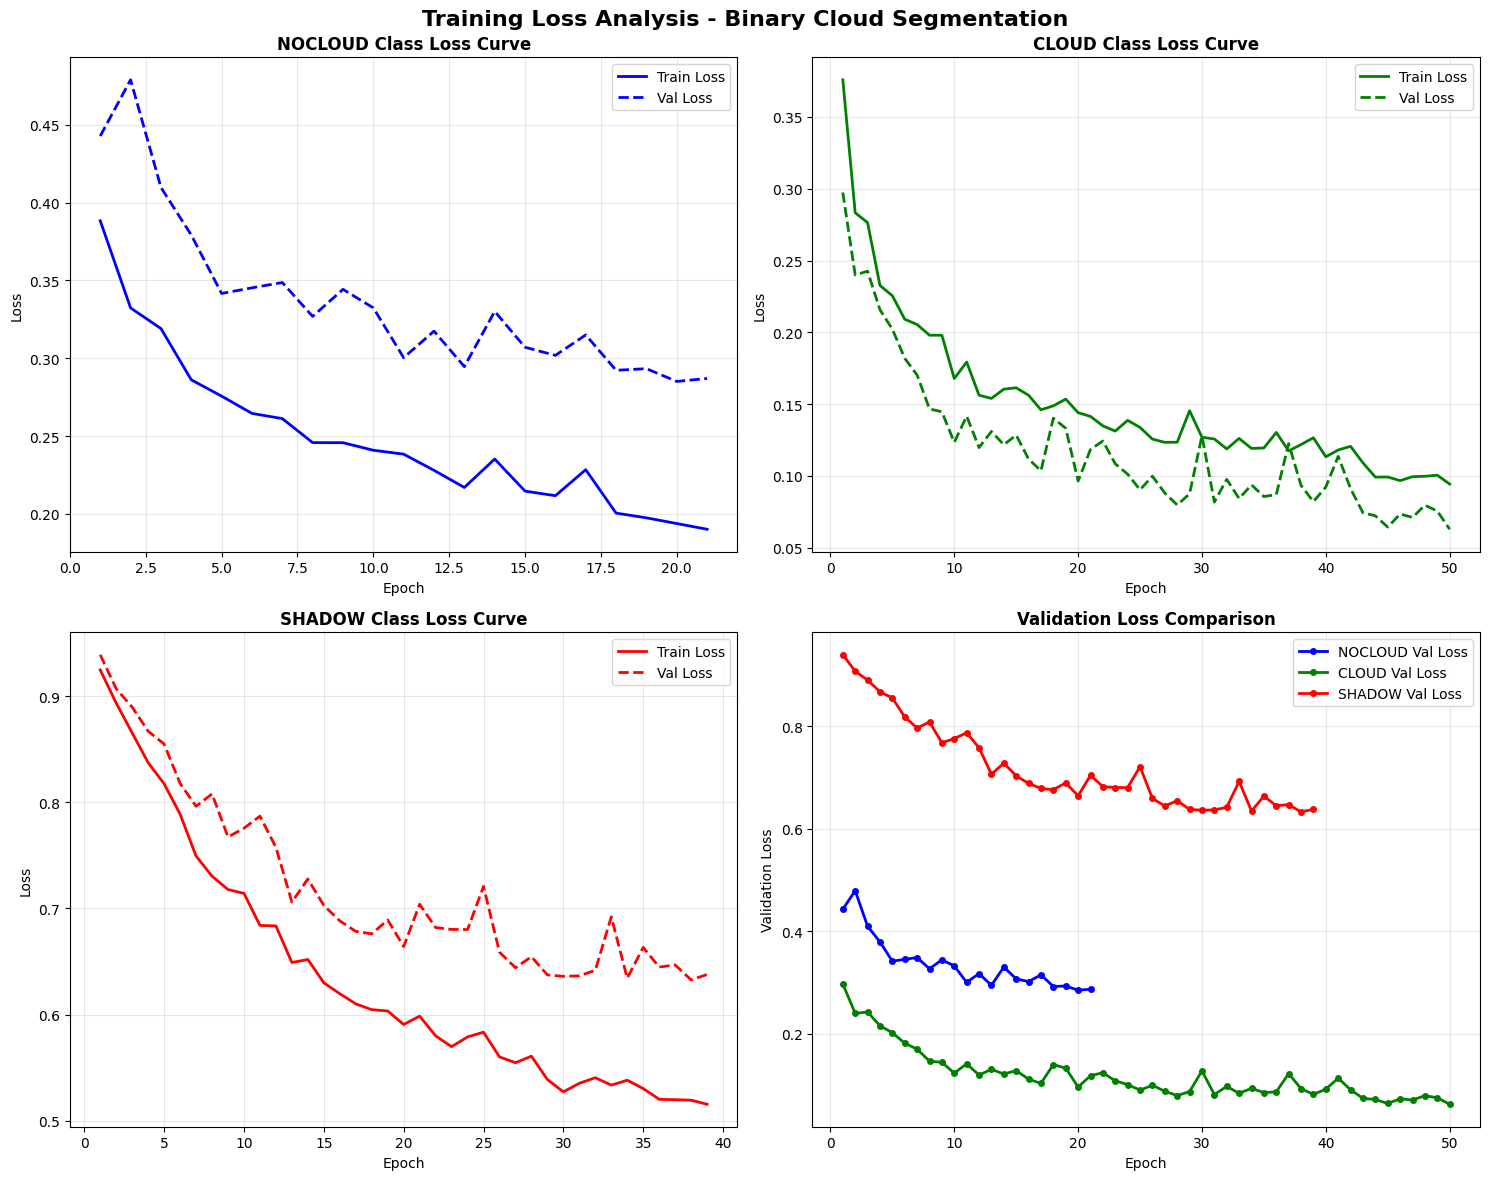

NOCLOUD : Best Combined IoU = 0.9154 at epoch 11
CLOUD   : Best Combined IoU = 0.9784 at epoch 45
SHADOW  : Best Combined IoU = 0.7844 at epoch 29


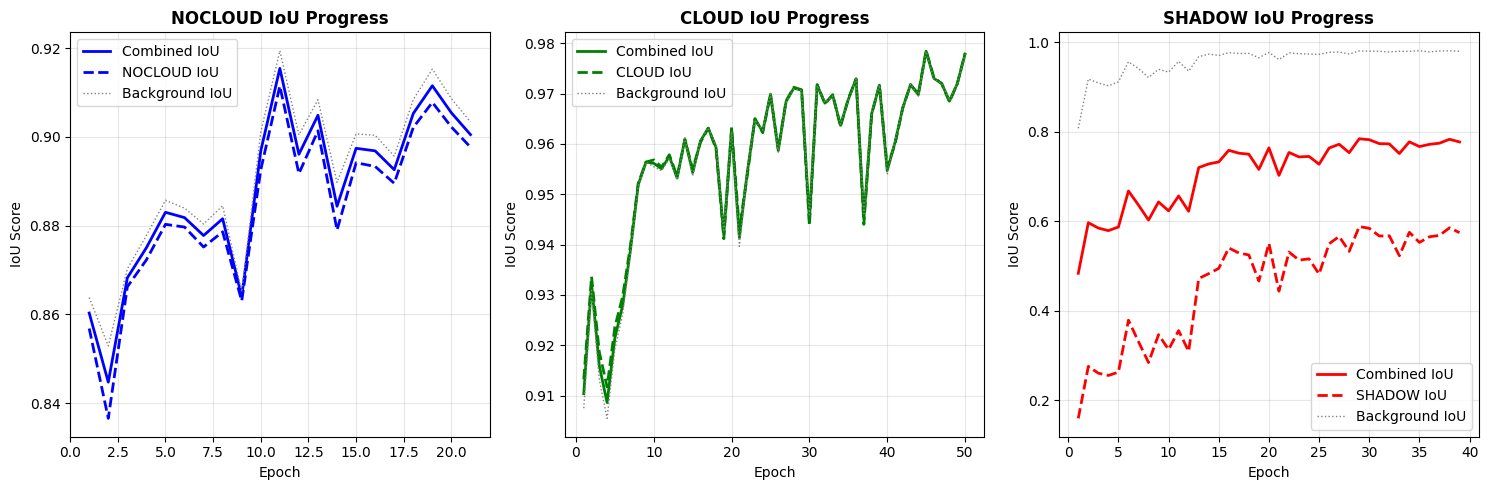

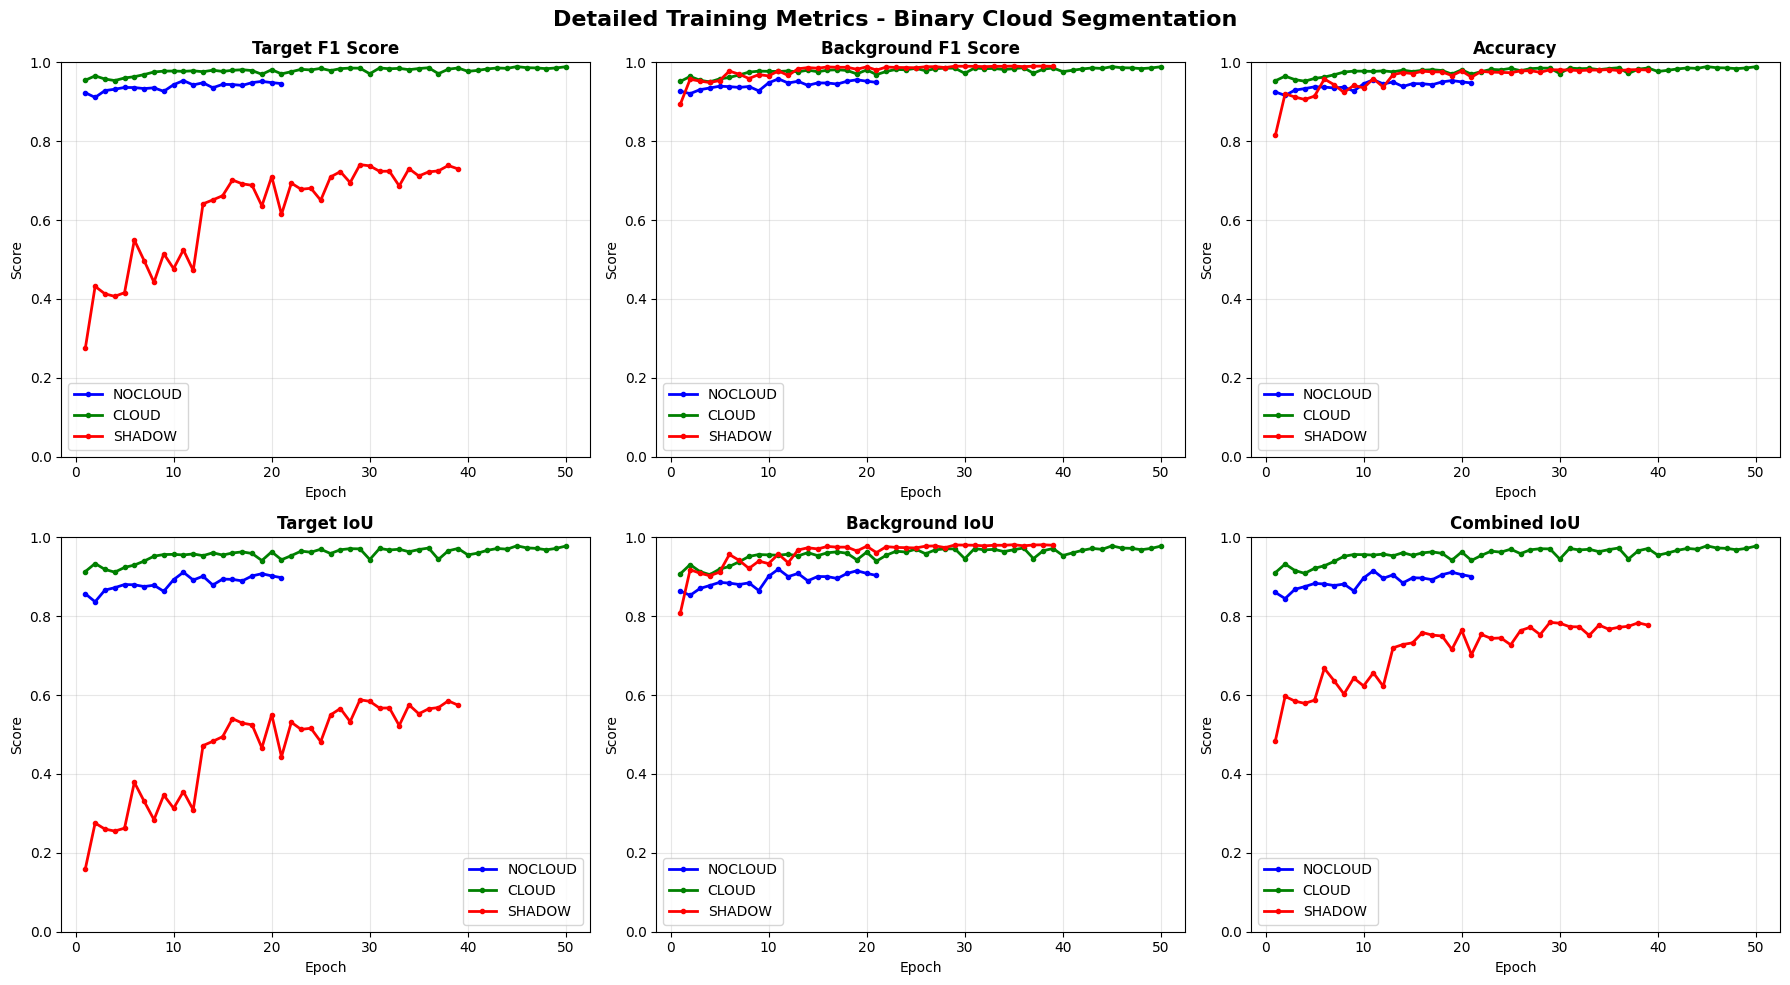


🎉 VISUALIZATION COMPLETE!
Saved files:
- training_loss_analysis.png
- training_iou_analysis.png
- detailed_metrics_analysis.png


In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_training_losses_from_json():
    """Create comprehensive loss graphs from training history JSON files"""
    
    print("📊 CREATING LOSS GRAPHS FROM TRAINING HISTORY")
    print("="*60)
    
    # Class information
    class_names = ['nocloud', 'cloud', 'shadow']
    class_labels = ['NOCLOUD', 'CLOUD', 'SHADOW']
    colors = ['blue', 'green', 'red']
    
    # Load training histories
    histories = {}
    for cls in class_names:
        filename = f'training_history_{cls}.json'
        try:
            with open(filename, 'r') as f:
                histories[cls] = json.load(f)
                print(f"✅ Loaded {filename}")
        except FileNotFoundError:
            print(f"❌ File not found: {filename}")
            histories[cls] = None
    
    # Create loss plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Training Loss Analysis - Binary Cloud Segmentation', fontsize=16, fontweight='bold')
    
    # Individual class loss curves (3 subplots)
    for i, (cls, label, color) in enumerate(zip(class_names, class_labels, colors)):
        history = histories.get(cls)
        if history is None:
            continue
            
        # Get loss data
        train_loss = history.get('train_loss', [])
        val_loss = history.get('val_loss', [])
        epochs = list(range(1, len(train_loss) + 1))
        
        # Plot individual class losses
        if i < 2:
            ax = axes[0, i]
        else:
            ax = axes[1, 0]
        
        ax.plot(epochs, train_loss, label=f'Train Loss', color=color, linewidth=2)
        ax.plot(epochs, val_loss, label=f'Val Loss', color=color, linestyle='--', linewidth=2)
        ax.set_title(f'{label} Class Loss Curve', fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Print final losses
        if train_loss and val_loss:
            print(f"{label:8}: Final Train Loss = {train_loss[-1]:.4f}, Final Val Loss = {val_loss[-1]:.4f}")
    
    # Combined comparison plot
    ax_combined = axes[1, 1]
    for cls, label, color in zip(class_names, class_labels, colors):
        history = histories.get(cls)
        if history is None:
            continue
            
        val_loss = history.get('val_loss', [])
        epochs = list(range(1, len(val_loss) + 1))
        
        ax_combined.plot(epochs, val_loss, label=f'{label} Val Loss', 
                        color=color, linewidth=2, marker='o', markersize=4)
    
    ax_combined.set_title('Validation Loss Comparison', fontweight='bold')
    ax_combined.set_xlabel('Epoch')
    ax_combined.set_ylabel('Validation Loss')
    ax_combined.legend()
    ax_combined.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_loss_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create IoU performance plot
    plt.figure(figsize=(15, 5))
    
    for i, (cls, label, color) in enumerate(zip(class_names, class_labels, colors)):
        history = histories.get(cls)
        if history is None:
            continue
            
        # Get IoU data
        val_combined_iou = history.get('val_combined_iou', [])
        val_target_iou = history.get('val_target_iou', [])
        val_bg_iou = history.get('val_bg_iou', [])
        epochs = list(range(1, len(val_combined_iou) + 1))
        
        plt.subplot(1, 3, i+1)
        plt.plot(epochs, val_combined_iou, label='Combined IoU', color=color, linewidth=2)
        plt.plot(epochs, val_target_iou, label=f'{label} IoU', color=color, linestyle='--', linewidth=2)
        plt.plot(epochs, val_bg_iou, label='Background IoU', color='gray', linestyle=':', linewidth=1)
        
        plt.title(f'{label} IoU Progress', fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('IoU Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Print best IoU
        if val_combined_iou:
            best_iou = max(val_combined_iou)
            best_epoch = val_combined_iou.index(best_iou) + 1
            print(f"{label:8}: Best Combined IoU = {best_iou:.4f} at epoch {best_epoch}")
    
    plt.tight_layout()
    plt.savefig('training_iou_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return histories

def create_detailed_metrics_plot(histories):
    """Create detailed metrics visualization"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Detailed Training Metrics - Binary Cloud Segmentation', fontsize=16, fontweight='bold')
    
    class_names = ['nocloud', 'cloud', 'shadow']
    class_labels = ['NOCLOUD', 'CLOUD', 'SHADOW']
    colors = ['blue', 'green', 'red']
    
    metrics_to_plot = [
        ('val_target_f1', 'Target F1 Score'),
        ('val_bg_f1', 'Background F1 Score'),
        ('val_accuracy', 'Accuracy'),
        ('val_target_iou', 'Target IoU'),
        ('val_bg_iou', 'Background IoU'),
        ('val_combined_iou', 'Combined IoU')
    ]
    
    for metric_idx, (metric_key, metric_label) in enumerate(metrics_to_plot):
        ax = axes[metric_idx // 3, metric_idx % 3]
        
        for cls, label, color in zip(class_names, class_labels, colors):
            history = histories.get(cls)
            if history is None:
                continue
                
            metric_values = history.get(metric_key, [])
            epochs = list(range(1, len(metric_values) + 1))
            
            ax.plot(epochs, metric_values, label=label, color=color, linewidth=2, marker='o', markersize=3)
        
        ax.set_title(metric_label, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Score')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig('detailed_metrics_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Usage
if __name__ == "__main__":
    # Create loss graphs
    histories = plot_training_losses_from_json()
    
    # Create detailed metrics plots
    if any(h is not None for h in histories.values()):
        create_detailed_metrics_plot(histories)
        
        print(f"\n🎉 VISUALIZATION COMPLETE!")
        print(f"Saved files:")
        print(f"- training_loss_analysis.png")
        print(f"- training_iou_analysis.png") 
        print(f"- detailed_metrics_analysis.png")
    else:
        print("❌ No training history files found!")
